# Модель fastText

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

import datetime
import requests
import collections as co
import string
import re

import nltk
from sumy.utils import get_stop_words as gsw1
from stop_words import get_stop_words as gsw2


import pandas as pd
import numpy as np

In [4]:
#чтение данных
df = pd.read_csv('./data/3categories_50.csv')
df.shape

(50000, 3)

In [5]:
df.head()

,channel,category,message
0,chat,afs,\nChat transcript:\nVisitor: I am attempting t...
1,chat,other,\nChat transcript:\nVisitor: Hi. For some reas...
2,chat,afs,"\nChat transcript:\nVisitor: Здравствуйте, я х..."
3,chat,afs,\nChat transcript:\nVisitor: no puedo hacer la...
4,chat,afs,\nChat transcript:\nVisitor: hi im trying to b...


In [6]:
#убираем технические данные в сообщениях и прочий шум
df['message'] = df['message'].str.replace('\[.*\]', '', regex=True)
df['message'] = df['message'].str.replace("\!", '', regex=True)
df['message'] = df['message'].str.replace("\'", '', regex=True)
df['message'] = df['message'].str.replace("[^A-Za-z0-9^,!.\/'+-=]", ' ', regex=True)

In [7]:
#переведем в нижний регистр
df['message'] = df['message'].str.replace("\s+", ' ', regex=True)
df['message'] = df['message'].str.lower()

In [8]:
#уберем шум
df.dropna(inplace = True)
df.shape

(49999, 3)

In [9]:
# уберем шумовые длинные сообщения
df['message_len'] = df['message'].str.len()
df = df[(df['message_len'] < np.percentile(df.message_len,99))][:]
df.shape

(49499, 4)

Очищаем текст от шума

In [10]:
df_reviews = df[['message']][:]
df_reviews.columns = ['review']
df_reviews.reset_index(drop = True , inplace = True)
df_reviews.shape

(49499, 1)

In [11]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mural\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mural\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
list_count_words = []
list_true_words = []
list_tagged = []
list_tags = []

for i ,row in  df_reviews.iterrows():
    words = []
    tagged = []
    true_words = []
    tags = []
    
    a_line = row['review']

    
    
    words = re.split(' ', a_line)
    true_words = []

    for word in words:
        m = re.search('(\w+)',word)
        if m is not None:
            good_word = m.group(0)
            true_words.append(good_word)

    tagged = nltk.pos_tag(true_words)
    tags = []
    for tag in tagged:
        tags.append(tag[1])
    



    list_count_words.append(len(words))   
    list_tagged.append(tagged)
    list_true_words.append(true_words)
    list_tags.append(tags)

In [13]:
df_reviews['count_words'] = list_count_words
df_reviews['list_of_words'] = list_true_words
df_reviews['list_of_tags'] = list_tags
df_reviews['word_with_tag_list'] = list_tagged

In [14]:
text_analizator_df = df_reviews[:]
text_analizator_df.rename(columns = {'review' : 'sentence'} , inplace = True)
text_analizator_df.head()

,sentence,count_words,list_of_words,list_of_tags,word_with_tag_list
0,chat transcript: visitor: i am attempting to ...,58,"[chat, transcript, visitor, i, am, attempting,...","[RB, JJ, NN, NN, VBP, VBG, TO, VB, PRP$, NN, R...","[(chat, RB), (transcript, JJ), (visitor, NN), ..."
1,chat transcript: visitor: hi. for some reason...,113,"[chat, transcript, visitor, hi, for, some, rea...","[RB, JJ, NN, NN, IN, DT, NN, PRP, VBZ, IN, PRP...","[(chat, RB), (transcript, JJ), (visitor, NN), ..."
2,"chat transcript: visitor: , faceit, andrew: ....",50,"[chat, transcript, visitor, faceit, andrew, vi...","[RB, JJ, NN, NN, VBD, NN, NN, NN, VBD, TO, VB,...","[(chat, RB), (transcript, JJ), (visitor, NN), ..."
3,chat transcript: visitor: no puedo hacer la r...,157,"[chat, transcript, visitor, no, puedo, hacer, ...","[RB, JJ, NN, DT, NN, NN, FW, FW, FW, NN, VBD, ...","[(chat, RB), (transcript, JJ), (visitor, NN), ..."
4,chat transcript: visitor: hi im trying to buy...,110,"[chat, transcript, visitor, hi, im, trying, to...","[RB, JJ, NN, NN, NN, VBG, TO, VB, NNS, CC, PRP...","[(chat, RB), (transcript, JJ), (visitor, NN), ..."


In [15]:
stopWords =nltk.corpus.stopwords.words()

LANGUAGE = 'english'

sw0 = ["yeah","zola","don"]
sw1 = gsw1(LANGUAGE)
sw2 = gsw2('en')

sw0.extend(list(sw1))
sw0.extend(list(sw2))



new_s_list = []
new_lw_list = []
new_lt_list = []
new_lwt_list = []
new_count_words = []

for s , lw , lt ,lwt in zip (text_analizator_df['sentence'] 
                        , text_analizator_df['list_of_words'] 
                        , text_analizator_df['list_of_tags']
                        , text_analizator_df['word_with_tag_list']):
    new_s = ''
    new_lw = []
    new_lt = []
    new_lwt = []
    for w,t,lw in zip(lw,lt,lwt):
        if t in ['NN','VB','DT','NNS','VBP','VB']:
            new_s += w + ' '
            new_lw.append(w)
            new_lt.append(t)
            new_lwt.append(lw)
        elif w in sw0 or re.match('\d+',w) is not None:
            continue

    
    new_s_list.append(new_s)
    new_lw_list.append(new_lw)
    new_lt_list.append(new_lt)
    new_lwt_list.append(new_lwt)
    new_count_words.append(len(new_lw))
        
text_analizator_df['new_sentence'] = new_s_list
text_analizator_df['list_of_words'] = new_lw_list
text_analizator_df['list_of_tags'] = new_lt_list
text_analizator_df['word_with_tag_list'] = new_lwt_list
text_analizator_df['count_words'] = new_count_words

In [16]:
text_analizator_df.head()

,sentence,count_words,list_of_words,list_of_tags,word_with_tag_list,new_sentence
0,chat transcript: visitor: i am attempting to ...,30,"[visitor, i, am, verify, card, the, payment, a...","[NN, NN, VBP, VB, NN, DT, NN, DT, NNS, VBP, NN...","[(visitor, NN), (i, NN), (am, VBP), (verify, V...",visitor i am verify card the payment all charg...
1,chat transcript: visitor: hi. for some reason...,64,"[visitor, hi, some, reason, sub, prepcoin, nl,...","[NN, NN, DT, NN, NN, NN, NN, NN, VBP, NN, NN, ...","[(visitor, NN), (hi, NN), (some, DT), (reason,...",visitor hi some reason sub prepcoin nl didnt g...
2,"chat transcript: visitor: , faceit, andrew: ....",17,"[visitor, faceit, visitor, hello, i, pay, a, s...","[NN, NN, NN, NN, NN, VB, DT, NN, DT, NN, NN, D...","[(visitor, NN), (faceit, NN), (visitor, NN), (...",visitor faceit visitor hello i pay a subscript...
3,chat transcript: visitor: no puedo hacer la r...,80,"[visitor, no, puedo, hacer, cash, infelizmente...","[NN, DT, NN, NN, NN, NN, NN, DT, NN, NN, NN, N...","[(visitor, NN), (no, DT), (puedo, NN), (hacer,...",visitor no puedo hacer cash infelizmente yo no...
4,chat transcript: visitor: hi im trying to buy...,48,"[visitor, hi, im, buy, bits, payment, be, hell...","[NN, NN, NN, VB, NNS, NN, VB, NN, NN, VB, DT, ...","[(visitor, NN), (hi, NN), (im, NN), (buy, VB),...",visitor hi im buy bits payment be hello im add...


In [17]:
df.shape

(49499, 4)

In [26]:
#подготовка данных для fasttext
data = df[['category', 'message']]
data['category'] = df['category']
data['message'] = text_analizator_df['new_sentence']
data.head()

<ipython-input-26-35b263881e45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['category'] = df['category']
<ipython-input-26-35b263881e45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['message'] = text_analizator_df['new_sentence']


,category,message
0,afs,visitor i am verify card the payment all charg...
1,other,visitor hi some reason sub prepcoin nl didnt g...
2,afs,visitor faceit visitor hello i pay a subscript...
3,afs,visitor no puedo hacer cash infelizmente yo no...
4,afs,visitor hi im buy bits payment be hello im add...


In [27]:
data = df[['category', 'message']]
data['category'] = data['category'].apply(lambda f: '__label__' + str(f))
data.head()

<ipython-input-27-0247c99187eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['category'] = data['category'].apply(lambda f: '__label__' + str(f))


,category,message
0,__label__afs,chat transcript: visitor: i am attempting to ...
1,__label__other,chat transcript: visitor: hi. for some reason...
2,__label__afs,"chat transcript: visitor: , faceit, andrew: ...."
3,__label__afs,chat transcript: visitor: no puedo hacer la r...
4,__label__afs,chat transcript: visitor: hi im trying to buy...


In [28]:
data[['category', 'message']].to_csv('train_data.txt', header=False, index=False, sep="\t")

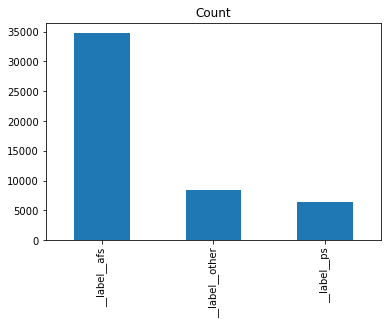

In [29]:
data['category'].value_counts().plot(kind='bar', title='Count');

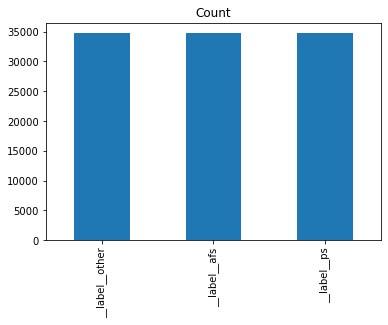

In [30]:
#сделаем оверсемплинг

from imblearn.over_sampling import RandomOverSampler
train_columns = list(set(data.columns) - set(['category']))
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(data[train_columns], data['category'])
y_ros.value_counts().plot(kind='bar', title='Count');

In [31]:
import fasttext

In [32]:
#обучение модели
model = fasttext.train_supervised(input='train_data.txt', epoch=100)

In [38]:
#проверка результата 
model.predict('hello i want to get money back',k=3)[1]

array([0.94549602, 0.04911341, 0.00542051])

In [34]:
#сохраняем модель для дальнейшего использования
model.save_model("./models/fastText_model.txt")